<a href="https://colab.research.google.com/github/Sopralapanca/TwitterDataset-DM-Project/blob/main/%5BDM%5D_Task_4_1_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider the tweets.csv dataset and only tweets posted in year = 2019. 
Extract for each user a time series representing Twitter's timeline. Compute for each day of the 2019 the following score:

$$SuccessScore = \frac{AcceptanceScore}{DiffusionScore+0.1}$$

where
* $AcceptanceScore = retweet\_count + reply\_count + favorite\_count$
* $DiffusionScore = num\_hashtag + num\_mentions + num\_urls$


The AcceptanceScore is considered to understand how much the social network enjoys the shared content. 
While the Diffusion Score describes the effort put on promoting the
tweet by the content creator.

Each value of the time series (one for each user) corresponds to the SuccessScore for a
certain day of 2019. In case a user did not post any tweets in a certain day, set the
SuccessScore = -1.

**The goal of this task is grouping similar users through the use of the created time series and, exploiting the binary variable bot, extracting shapelets**

#Setup

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib as mpl
import time
import math
import calendar
import os
from os import path
from sys import getsizeof
from tqdm import tqdm
import pandas as pd

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
!pip install --upgrade --no-cache-dir gdown &> /dev/null

In [ ]:
# download data from google drive
if not path.exists('users_final.parquet.gzip'):
  users_fileid = "1cG6TcjL5DygWGTsThL9CT9XJRqfueg_G"
  tweets_fileid = "1-11MPaJhQI0aGaH1ND9QMFgoJAXaD6cF"

  !gdown $users_fileid
  !gdown $tweets_fileid

Downloading...
From: https://drive.google.com/uc?id=1cG6TcjL5DygWGTsThL9CT9XJRqfueg_G
To: /content/users_final.parquet.gzip
100% 1.18M/1.18M [00:00<00:00, 184MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-11MPaJhQI0aGaH1ND9QMFgoJAXaD6cF
To: /content/tweets_final.parquet.gzip
100% 494M/494M [00:04<00:00, 112MB/s]


In [ ]:
tweet_path = "tweets_final.parquet.gzip"
user_path = "users_final.parquet.gzip"

# max_rows is used to load a portion of the dataset
max_rows = 0
 
users_df = pd.read_parquet(user_path) 

if max_rows != 0:
  tweets_df = pd.read_parquet(tweet_path, nrows=max_rows)
else:
  tweets_df = pd.read_parquet(tweet_path)

In [ ]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10860709 entries, 0 to 10860708
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   user_id         int64         
 2   retweet_count   int64         
 3   reply_count     int64         
 4   favorite_count  int64         
 5   num_hashtags    int64         
 6   num_urls        int64         
 7   num_mentions    int64         
 8   created_at      datetime64[ns]
 9   text            string        
 10  is_retweet      boolean       
 11  length          Int64         
dtypes: Int64(1), boolean(1), datetime64[ns](1), int64(8), string(1)
memory usage: 942.5 MB


In [ ]:
tweets_df = tweets_df.drop(columns=["text", "id","is_retweet", "length"])

In [ ]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10860709 entries, 0 to 10860708
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
dtypes: datetime64[ns](1), int64(7)
memory usage: 662.9 MB


In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         11508 non-null  int64         
 1   name                            11508 non-null  string        
 2   lang                            11508 non-null  object        
 3   bot                             11508 non-null  int64         
 4   subscription_date               11508 non-null  datetime64[ns]
 5   statuses_count                  11508 non-null  float64       
 6   number_of_tweets                11508 non-null  int64         
 7   tweets_2019                     11508 non-null  int64         
 8   tweets_2020                     11508 non-null  int64         
 9   likes_sum                       11508 non-null  int64         
 10  likes_mean                      11508 non-null  int64         
 11  li

# Utilities

In [ ]:
def plot_timeseries(data, user_id=None):
  sns.set(rc={'figure.figsize': (30, 7)})
  sns.lineplot(data=data)

  plt.xlabel("Date")
  plt.ylabel("Success Score")
  
  if user_id!=None:
    plt.title("User #"+str(user_id))

  plt.show()

# Generate the time series

The following code is used to build the timeseries of the success score per user

In [ ]:
# we compute the acceptance score and the diffusion score
# if a user made more than one tweet on a day we comput the mean of the acceptance score and diffusion score
def compute_acceptance_score(df, day):
    item = (df[df['created_at'] == day]).mean()
    return item['retweet_count'] + item['reply_count'] + item['favorite_count']
def compute_diffusion_score(df, day):
    item = (df[df['created_at'] == day]).mean()
    return item['num_hashtags'] + item['num_urls'] + item['num_mentions']


def success_score(df, day):
    if len(df[df['created_at'] == day]) == 0:
        return -1
    else:
        try:
          acceptance_score = compute_acceptance_score(df, day)
          diffusion_score = compute_diffusion_score(df, day)
          return acceptance_score / (diffusion_score+0.1)
        except:
          return -1

In [ ]:
def extract_success_score_timeseries(user_id):

    df = tweets_df[tweets_df['user_id'] == user_id]

    # remove the time
    df['created_at'] = df['created_at'].dt.date


    df = df.sort_values(by=['created_at'])

    values = []
    labels = []
    for day in pd.date_range(start="2019-01-01", end="2019-12-31"):
        values.append(success_score(df, day))
        labels.append(day)

    return values,labels

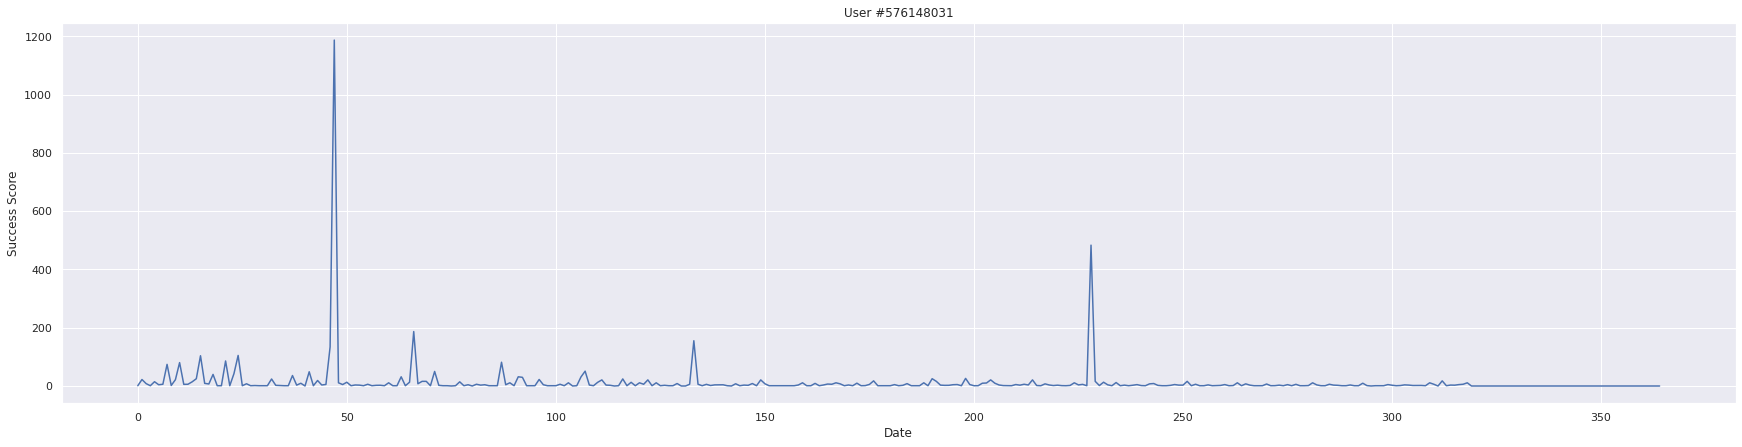

In [ ]:
# plot the timeseries for a user
example_user_id = 576148031
values, labels = extract_success_score_timeseries(example_user_id)
plot_timeseries(values, example_user_id)

# Building the timeseries dataframe

Now we create a dataframe containing one timeseries as list of points for each user. Since the construction of the timeseries for each user takes a long time, we generated the timeseries and saved the dataframe on the cloud once and for all. We will then download the new dataset and work on that

In [ ]:
generate_time_series = False

In [ ]:
file_name = "timeseries_df.parquet.gzip"

In [ ]:
if generate_time_series==True:
  from google.colab import drive
  timeseries_df = pd.DataFrame(columns=["user_id", "values", "bot"])

  for user_id in tqdm(tweets_df["user_id"].unique()):
      values, labels = extract_success_score_timeseries(user_id)
      bot = users_df[users_df['user_id'] == user_id]["bot"].values[0]

      timeseries_df = timeseries_df.append({"user_id":  user_id, 
                                            "values":   values,
                                            "bot":      bot}
                                          , ignore_index=True)
  # Saving the dataframe
  drive.mount('/content/drive')
  path = "/content/drive/MyDrive/"+file_name
  timeseries_df.to_parquet(path,compression='gzip')

In [ ]:
if generate_time_series==False:
  timeseries_fileid = "1-A6IeVbXUaWAGMjrmvvAnukY_CBUzzg8"
  !gdown $timeseries_fileid
  
  timeseries_df = pd.read_parquet(file_name) 

Downloading...
From: https://drive.google.com/uc?id=1-A6IeVbXUaWAGMjrmvvAnukY_CBUzzg8
To: /content/timeseries_df.parquet.gzip
100% 1.41M/1.41M [00:00<00:00, 66.3MB/s]


In [ ]:
# values is the column containing the timeseries for each user
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  11508 non-null  int64 
 1   values   11508 non-null  object
 2   bot      11508 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 269.8+ KB


In [ ]:
timeseries_df.head()

,user_id,values,bot
0,327746321,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1
1,333722906,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0
2,2379755827,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1
3,466226882,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1
4,1355537995,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0


### Cleaning the timeseries

Since timeseries of all "-1" are present on the dataset, we delete all users who did not tweet anything in 2019 from the dataframe.

In [ ]:
len_original_df = len(timeseries_df)

In [ ]:
for index, row in timeseries_df.iterrows():
    ts = row["values"]
    the_user_id = row["user_id"]
    
    if all(x == -1 for x in ts): # If the user have only -1s 
      timeseries_df = timeseries_df[timeseries_df.user_id != the_user_id] # Remove it

In [ ]:
print("Deleted",len_original_df - len(timeseries_df),"users")

Deleted 4610 users


# Setup the dataset

In [ ]:
X = timeseries_df["values"].values
y = timeseries_df["bot"].values
y = np.int_(y)

In [ ]:
tmp_X = []
for x in X:
  tmp_X.append(pd.Series(x))
X = tmp_X

# Removing noise using a slinding window





In [ ]:
ts_example = X[30]

In [ ]:
windows_size = 40

In [ ]:
def remove_noise(ts,w):
    ts = ts.rolling(window=w, min_periods=1).mean()
    return ts

In [ ]:
# Remove noise over all the dataset
tmp_X = []
for ts in tqdm(X):
  tmp_X.append(remove_noise(ts,windows_size))
X = tmp_X

100%|██████████| 6898/6898 [00:01<00:00, 5934.47it/s]


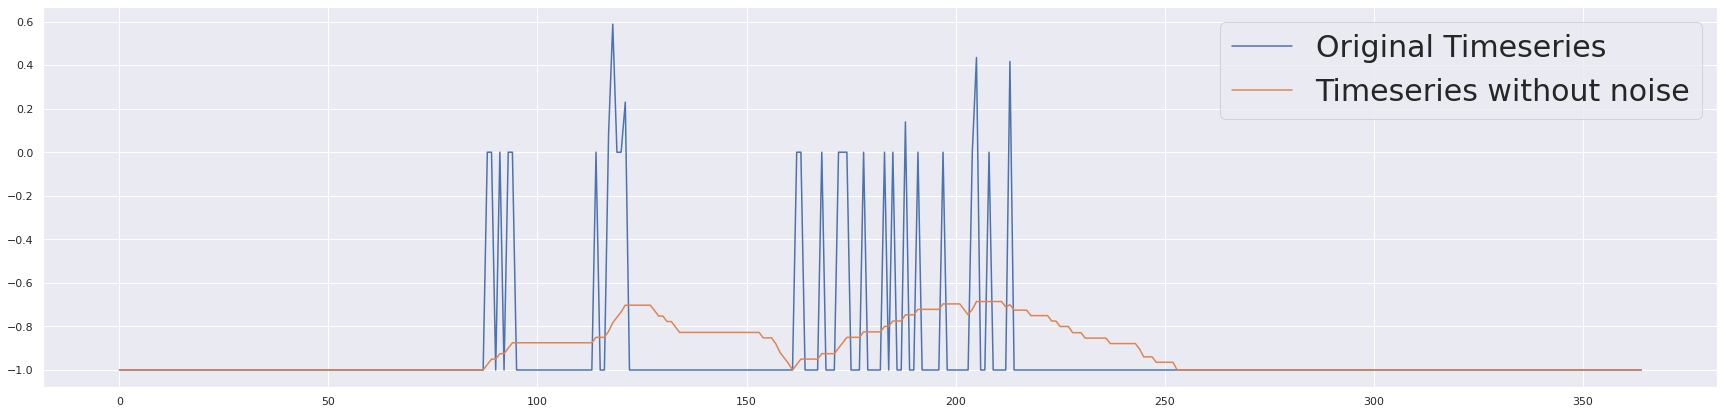

In [ ]:
ts_example_without_noise = X[30]
plt.plot(ts_example, label="Original Timeseries")
plt.plot(ts_example_without_noise, label="Timeseries without noise")
plt.legend(prop={'size': 30})
plt.show()

# Normalization

In [ ]:
!pip install tslearn &> /dev/null

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
scaler = TimeSeriesScalerMinMax(value_range=(0.0, 1.))  

def ts_norm(ts):
  ts_reshaped = ts.values.reshape(1, -1)
  return scaler.fit_transform(ts_reshaped).flatten()

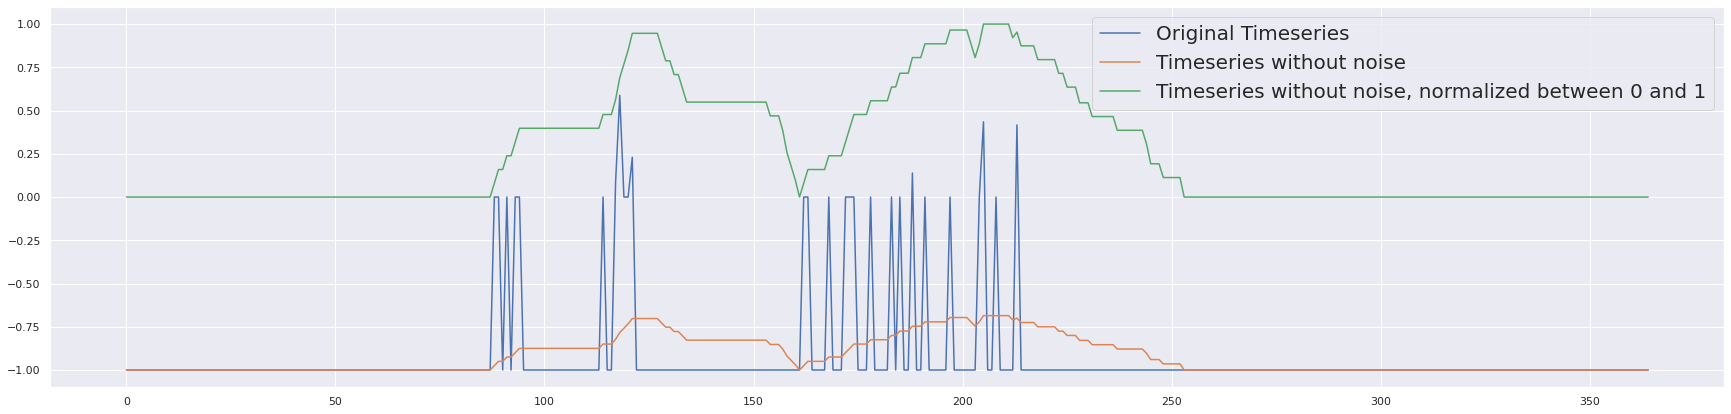

In [ ]:
ts_example_norm = ts_norm(ts_example_without_noise)

plt.plot(ts_example, label="Original Timeseries")
plt.plot(ts_example_without_noise, label="Timeseries without noise")
plt.plot(ts_example_norm, label="Timeseries without noise, normalized between 0 and 1")
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
# Normalize all the dataset
tmp_X = []
for ts in tqdm(X):
  tmp_X.append(ts_norm(ts))
X = tmp_X

100%|██████████| 6898/6898 [00:01<00:00, 3952.33it/s]


# Clustering

In [ ]:
!pip install kneed &> /dev/null

## Shape-Based clustering

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from kneed import KneeLocator

In [ ]:
def knee_method(x_ax, y_ax, direction='increasing', labelx="", labely="", returnX=True, show_plot=True):
  knee = KneeLocator(x_ax, y_ax, S=1, curve='convex', direction=direction, interp_method='polynomial')
  if show_plot:
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.grid(visible=True)
    plt.show()
  return knee.knee

In [ ]:
def visualize_clustering_results(data):
  g = sns.pairplot(data = data, hue = "cluster", plot_kws={"s": 35})
  g.fig.set_size_inches(20,15)

In [ ]:
def bot_per_cluster(clusering_alg, categorical_features):
  bot = pd.crosstab(clusering_alg.labels_,categorical_features['bot'])
  bot.plot(kind='bar', stacked=False,
              title='Bot per cluster',
              figsize=(10, 8))
  plt.xlabel('Cluster')
  plt.ylabel('Bot')
  plt.show()

In [ ]:
X_new = np.array(X)
X_new.shape

(6898, 365)

In [ ]:
# adjust dimension for timeserieskmeans
X_new = X_new[..., np.newaxis]
X_new.shape

(6898, 365, 1)

In [ ]:
sse_list = list()
k_list   = list()
n_init   = 5
max_iter = 50
metric   = "euclidean"
max_k    = 15
for k in range(2, max_k + 1):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric=metric, n_init=n_init, max_iter=max_iter)
    kmeans.fit(X_new)
    sse = kmeans.inertia_
    sse_list.append(sse)
    k_list.append(k)
    print("k = ", k, "| sse=", sse)

k =  2 | sse= 15.58654284088064
k =  3 | sse= 11.668828109777426
k =  4 | sse= 10.29397043938193
k =  5 | sse= 9.39435008671885
k =  6 | sse= 8.743878656590391
k =  7 | sse= 7.987550921299146
k =  8 | sse= 7.332234739255288
k =  9 | sse= 6.952357340527854
k =  10 | sse= 6.623136573462485
k =  11 | sse= 6.251732157672104
k =  12 | sse= 5.950319801498902
k =  13 | sse= 5.753558821266001
k =  14 | sse= 5.498120507973778
k =  15 | sse= 5.304525863351353


<Figure size 360x360 with 0 Axes>

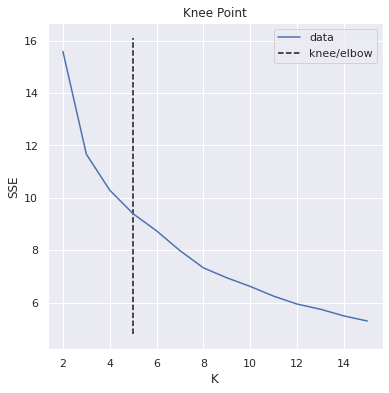

Best K is 5


In [ ]:
best_k = knee_method(k_list, sse_list, "decreasing", "K", "SSE", True)
print("Best K is", best_k)

In [ ]:
%%time
n_clusters=best_k
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, n_init=n_init, metric=metric, max_iter=max_iter)
kmeans.fit(X_new)
print("SSE: ",kmeans.inertia_)

SSE:  9.394147654851217
CPU times: user 30.6 s, sys: 1.78 s, total: 32.4 s
Wall time: 32.4 s


Plotting centroids, note that working with timeseries, the centroids themselves are timeseries.

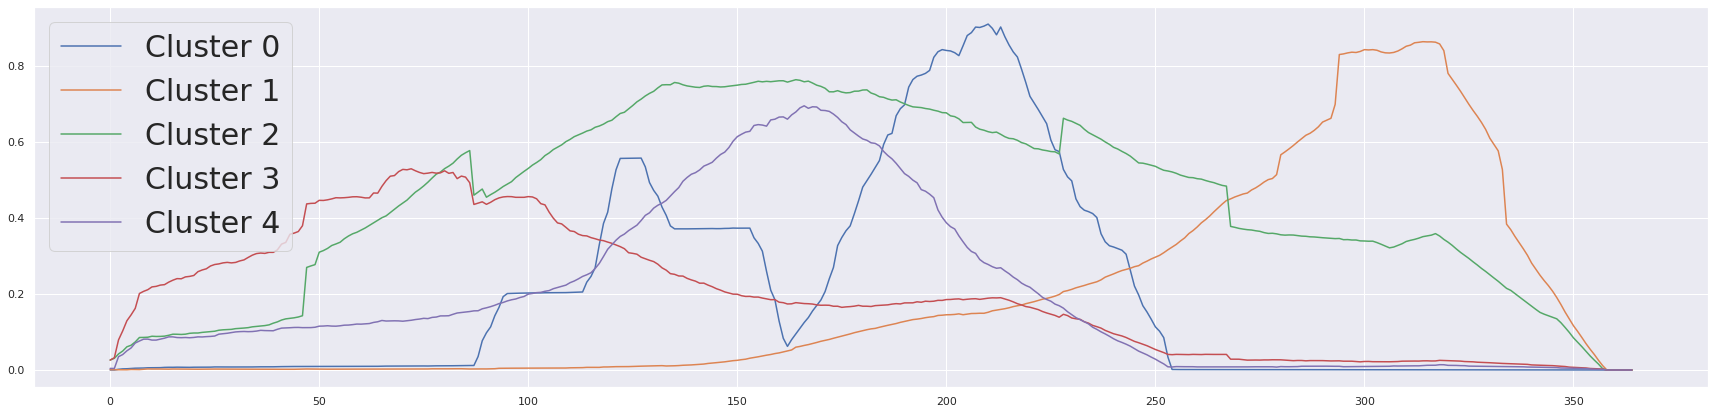

In [ ]:
for i in range(n_clusters):
    plt.plot(np.mean(X_new[np.where(kmeans.labels_ == i)[0]], axis=0), label=f"Cluster {i}")
plt.legend(prop={'size': 30})
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
s_sil_score = silhouette_score(X, kmeans.labels_)

In [ ]:
print("Silhouette score:",s_sil_score)

Silhouette score: 0.44066148871479593


## Feature-based clustering

In [ ]:
import scipy.stats as stats
import numpy as np

# from timseries to a vector of feature, then we can use classical clustering algorithms like kmeans
def calculate_features(df, values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values)[0],
        'kur': stats.kurtosis(values)[0]
    }
    df = df.append(features, ignore_index=True)
    return df

In [ ]:
df = pd.DataFrame(columns=['avg','std','var','med','10p',
                           '25p','50p','75p','90p','iqr','cov',
                           'skw','kur'])
for ts in X_new:
  df = calculate_features(df, ts)

In [ ]:
df.head()

,avg,std,var,med,10p,25p,50p,75p,90p,iqr,cov,skw,kur
0,0.164979,0.312118,0.097418,0.000000,0.000000,0.00000,0.000000,0.135312,0.792744,0.135312,0.528577,1.658194,1.162761
1,0.199867,0.292198,0.085379,0.000000,0.000000,0.00000,0.000000,0.400772,0.692273,0.400772,0.684012,1.331304,0.546133
2,0.217438,0.286306,0.081971,0.103833,0.000000,0.00000,0.103833,0.356387,0.831356,0.356387,0.759460,1.372074,0.782493
3,0.118976,0.163916,0.026868,0.047592,0.000000,0.00000,0.047592,0.217375,0.395225,0.217375,0.725834,1.717170,3.082505
4,0.267373,0.252886,0.063951,0.170135,0.043941,0.13225,0.170135,0.312040,0.869233,0.179790,1.057287,1.698287,1.936890


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   avg     6898 non-null   float64
 1   std     6898 non-null   float64
 2   var     6898 non-null   float64
 3   med     6898 non-null   float64
 4   10p     6898 non-null   float64
 5   25p     6898 non-null   float64
 6   50p     6898 non-null   float64
 7   75p     6898 non-null   float64
 8   90p     6898 non-null   float64
 9   iqr     6898 non-null   float64
 10  cov     6898 non-null   float64
 11  skw     6898 non-null   float64
 12  kur     6898 non-null   float64
dtypes: float64(13)
memory usage: 700.7 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df.values)

scaled_values = scaler.transform(df.values)

df_scaled = pd.DataFrame(scaled_values, columns=df.columns)

In [ ]:
from sklearn.cluster import KMeans

sse_list = list()
k_list = list()
n_init=30
max_iter=300
max_k = 15
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(scaled_values)
    sse = kmeans.inertia_
    sse_list.append(sse)
    k_list.append(k)
    print("k = ", k, "\t\t| sse=", sse)

k =  2 		| sse= 686.0825713973086
k =  3 		| sse= 427.4272662803408
k =  4 		| sse= 359.9646628133428
k =  5 		| sse= 306.11043706280714
k =  6 		| sse= 262.4571592200961
k =  7 		| sse= 228.98368514962905
k =  8 		| sse= 201.75080375298091
k =  9 		| sse= 184.31713265308522
k =  10 		| sse= 168.25800266570178
k =  11 		| sse= 157.18374577189627
k =  12 		| sse= 147.3752649015822
k =  13 		| sse= 138.88936956863182
k =  14 		| sse= 131.6624309150929
k =  15 		| sse= 124.57698841510226


<Figure size 360x360 with 0 Axes>

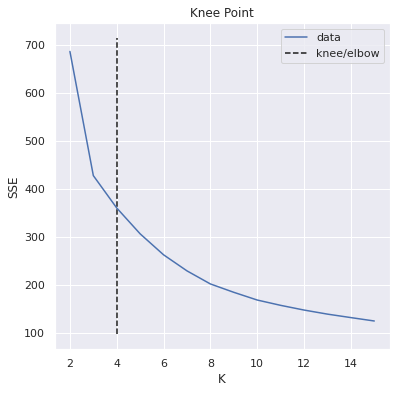

Best K is  4


In [ ]:
best_k = knee_method(k_list, sse_list, "decreasing", "K", "SSE", True)
print("Best K is ", best_k)

In [ ]:
n_clusters=best_k

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init,
                max_iter=max_iter)
kmeans.fit(scaled_values)
print("SSE: ",kmeans.inertia_)

SSE:  359.96448475723776


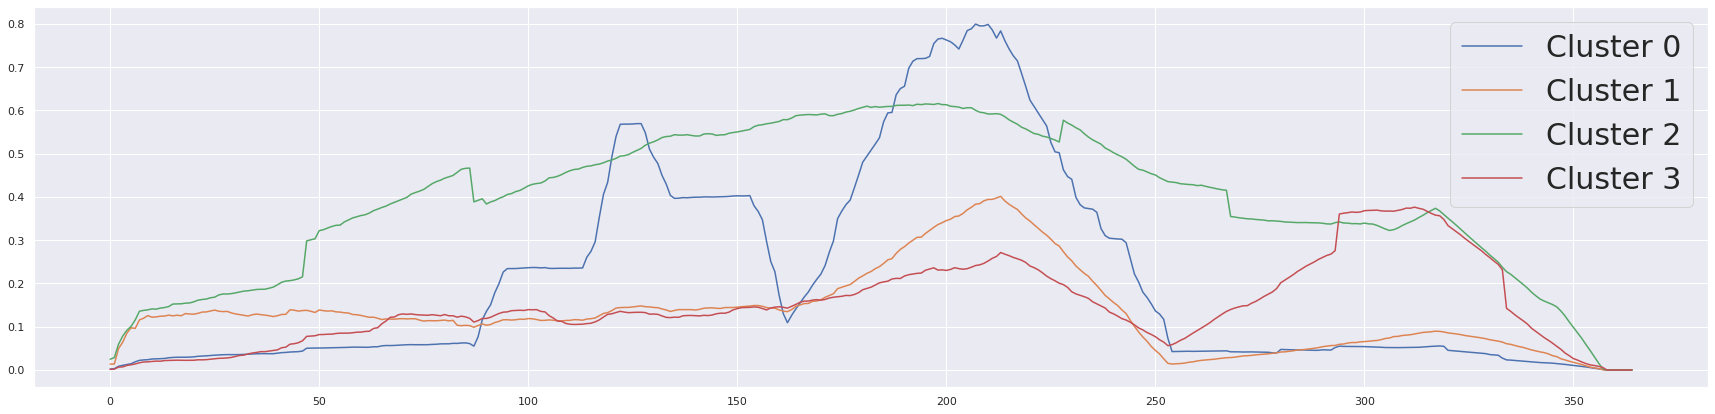

In [ ]:
# we need a way to correctly plot the centroids, since the data were a timeseries
# we compute the mean of all the timeseries on the same cluster
for i in range(n_clusters):
    plt.plot(np.mean(X_new[np.where(kmeans.labels_ == i)[0]], axis=0), label=f"Cluster {i}")
plt.legend(prop={'size': 30})
plt.show()

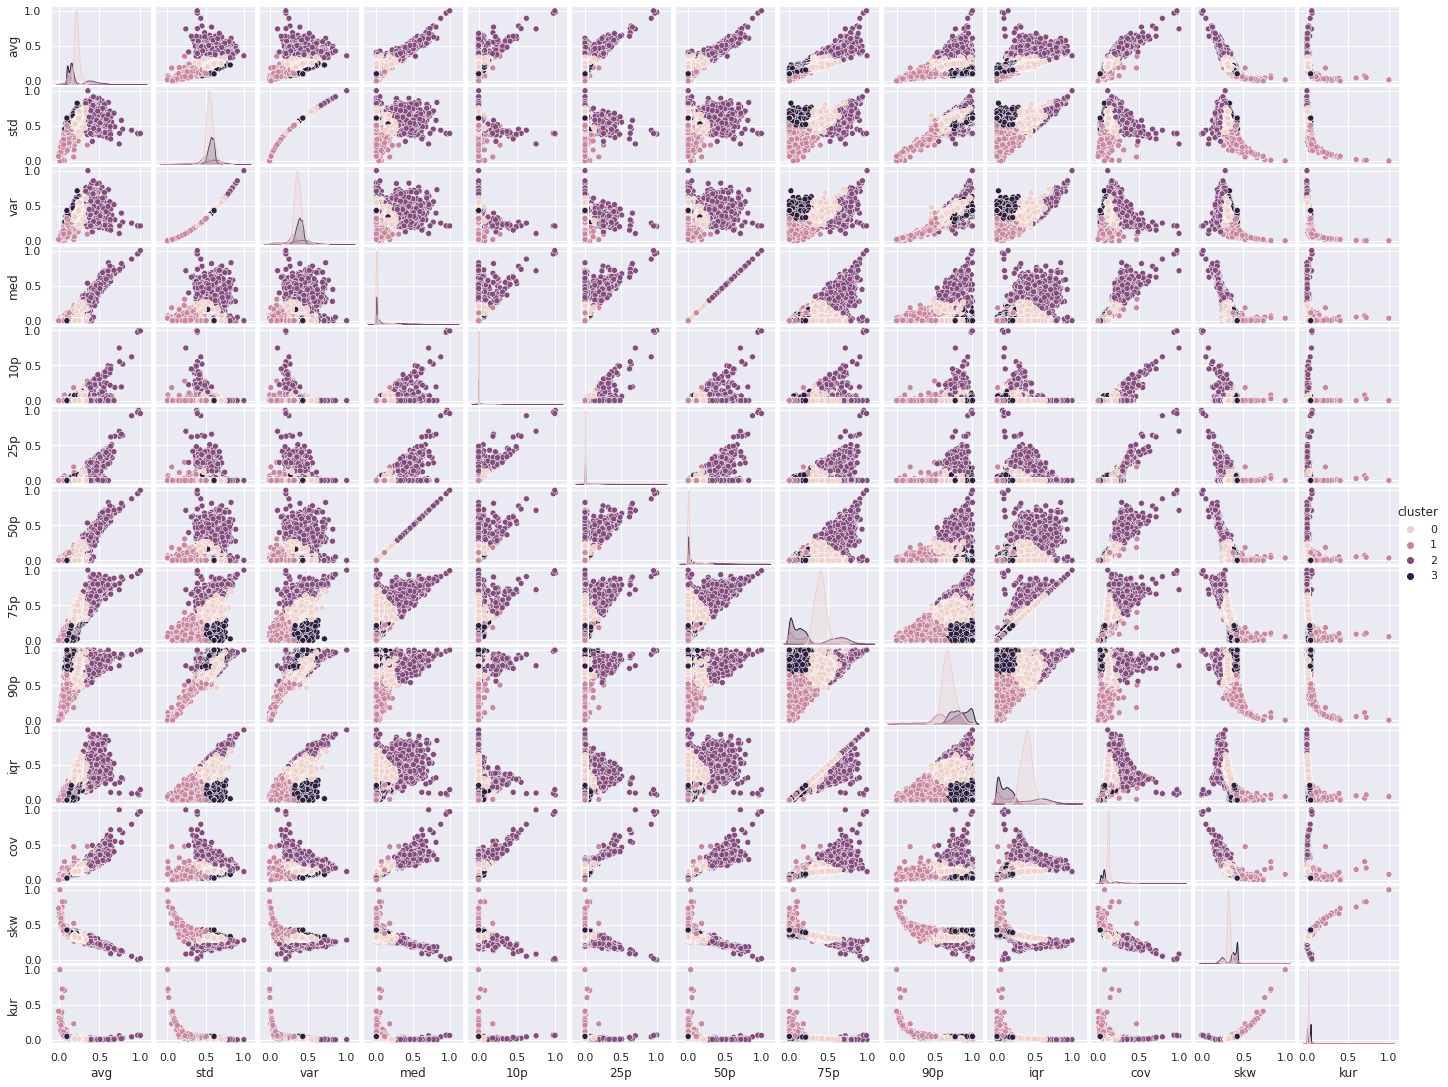

In [ ]:
df_scaled["cluster"] = kmeans.labels_
visualize_clustering_results(data=df_scaled)

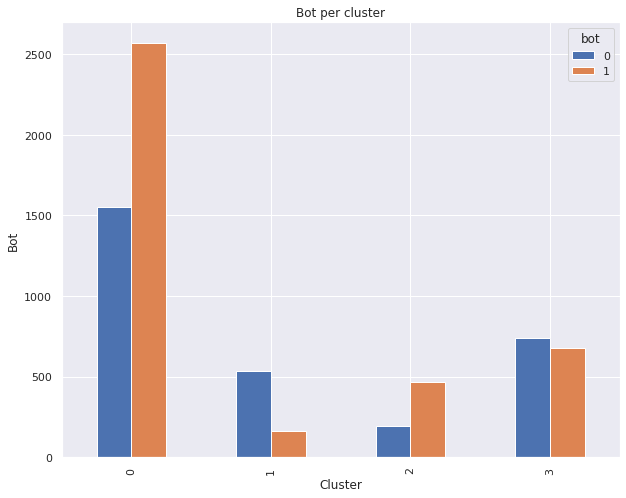

In [ ]:
bot_per_cluster(kmeans, timeseries_df)

In [ ]:
labels = kmeans.predict(scaled_values)
score = silhouette_score(scaled_values, labels)
print("Silhouette score:",score)
f_sil_score=score

Silhouette score: 0.4600047906735633


# Classification

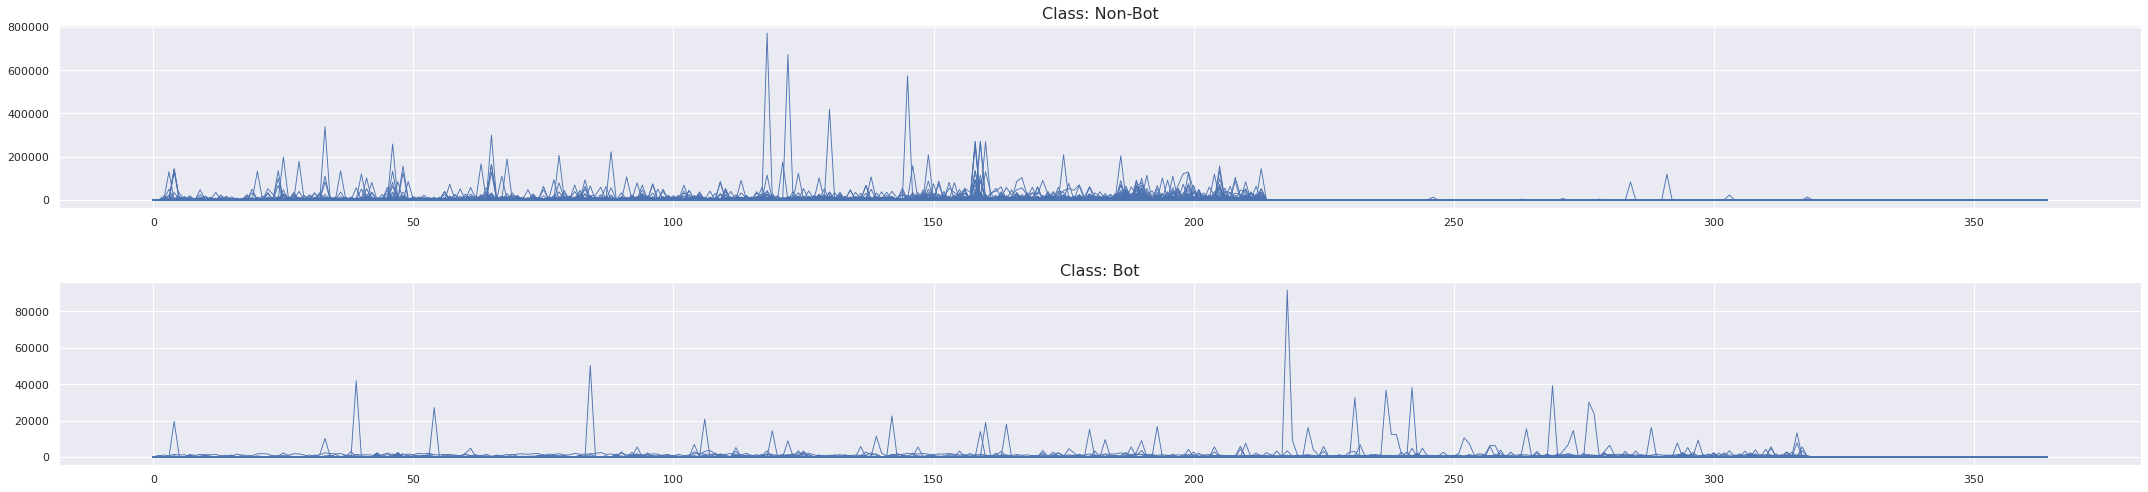

In [ ]:
X = timeseries_df["values"].values
y = timeseries_df["bot"].values

plt.figure()
for i, classe in enumerate(['Non-Bot', 'Bot']):
    plt.subplot(2, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
y = np.int_(y)

In [ ]:
# then we use the already normalized timeseries X_new

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5518, 365, 1)
(1380, 365, 1)
(5518,)
(1380,)


## Model Selection

In [ ]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.shapelets import LearningShapelets
import tensorflow as tf

In [ ]:
# costants
n_ts = X_train.shape[0]
ts_sz = X_train.shape[1]

n_classes = len(set(y))

In [ ]:
def build_model(shapelet_length, learnging_rate, epochs, weight_regularizer, verbose=0):
  shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=shapelet_length,
                                                       r=1)
  
  shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                        optimizer=tf.optimizers.Adam(learning_rate=learnging_rate),
                        max_iter=epochs,
                        weight_regularizer=weight_regularizer,
                        verbose=verbose,
                        scale=False,
                        random_state=42)
  return shp_clf, shapelet_sizes

In [ ]:
compute_model_selection = False

In [ ]:
import random
from warnings import simplefilter
import itertools as it
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# parameters grid
param_grid = {
        "shapelet_length": [0.05, 0.1, 0.15, 0.2, 0.25],
        'learnging_rate': [0.0001, 0.001, 0.01, 0.1],
        "epochs": [20, 30, 40, 50, 70],
        "weight_regularizer": [0.0, 0.1, 0.001, 0.0001]
}

if compute_model_selection:
  # compute the list of all the possible combination
  keys = param_grid.keys()
  combinations = it.product(*(param_grid[key] for key in keys))
  param_list = list(combinations)

  # choose randomly 30 of them
  param_list = list(random.choices(param_list, k=30))

  # dataframe to store the results
  df_output_columns = list(param_grid.keys())
  dataframe_output_columns = df_output_columns
  dataframe_output_columns.append("loss")
  dataframe_output_columns.append("accuracy")
  random_search_df = pd.DataFrame(columns=dataframe_output_columns)

  n_combinations = len(param_list)


  # compute list of args passed as parameters to the process
  for i, elem in enumerate(param_list):
      shapelet_length = elem[0]
      learnging_rate = elem[1]
      epochs = elem[2]
      weight_regularizer = elem[3]

      print(f"combination {i+1}/{n_combinations} {elem}")
      model, _ = build_model(shapelet_length, learnging_rate, epochs, weight_regularizer, verbose=1)
      model.fit(X_train, y_train)

      loss = model.history_["loss"][-1]
      accuracy = model.history_["binary_accuracy"][-1]
      
      row = {'shapelet_length':shapelet_length, "learnging_rate":learnging_rate, 
            "epochs":epochs, "weight_regularizer":weight_regularizer, 
            "loss":loss, "accuracy":accuracy}
      
      random_search_df = random_search_df.append(row, ignore_index=True)

In [ ]:
if compute_model_selection:
  random_search_df.sort_values(by=['accuracy'], inplace=True, ascending=False)
  
  random_search_df

## Refit best model

In [ ]:
if compute_model_selection:
  # take the best one
  row = random_search_df.iloc[0]
  shapelet_length = float(row["shapelet_length"])
  learnging_rate = float(row["learnging_rate"])
  epochs = int(row["epochs"])
  weight_regularizer = float(row["weight_regularizer"])

else:
  shapelet_length = 0.25
  learnging_rate = 0.1000
  epochs = 20
  weight_regularizer = 0.0000

In [ ]:
shp_clf, shapelet_sizes = build_model(shapelet_length, learnging_rate, epochs, weight_regularizer, verbose=1)
shp_clf.fit(X_train, y_train)

Epoch 1/20
22/22 [==============================] - 8s 6ms/step - loss: 0.6162 - binary_accuracy: 0.6446 - binary_crossentropy: 0.6162
Epoch 2/20
22/22 [==============================] - 0s 6ms/step - loss: 0.5489 - binary_accuracy: 0.7276 - binary_crossentropy: 0.5489
Epoch 3/20
22/22 [==============================] - 0s 5ms/step - loss: 0.5326 - binary_accuracy: 0.7224 - binary_crossentropy: 0.5326
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - loss: 0.5081 - binary_accuracy: 0.7532 - binary_crossentropy: 0.5081
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 0.5142 - binary_accuracy: 0.7398 - binary_crossentropy: 0.5142
Epoch 6/20
22/22 [==============================] - 0s 7ms/step - loss: 0.5100 - binary_accuracy: 0.7497 - binary_crossentropy: 0.5100
Epoch 7/20
22/22 [==============================] - 0s 7ms/step - loss: 0.4943 - binary_accuracy: 0.7595 - binary_crossentropy: 0.4943
Epoch 8/20
22/22 [==============================] - 0s 

LearningShapelets(max_iter=20, n_shapelets_per_size={91: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7fe9c54e42b0>,
                  random_state=42, verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score
# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

6/6 [==============================] - 0s 8ms/step
Correct classification rate: 0.7789855072463768


22/22 [==============================] - 0s 7ms/step


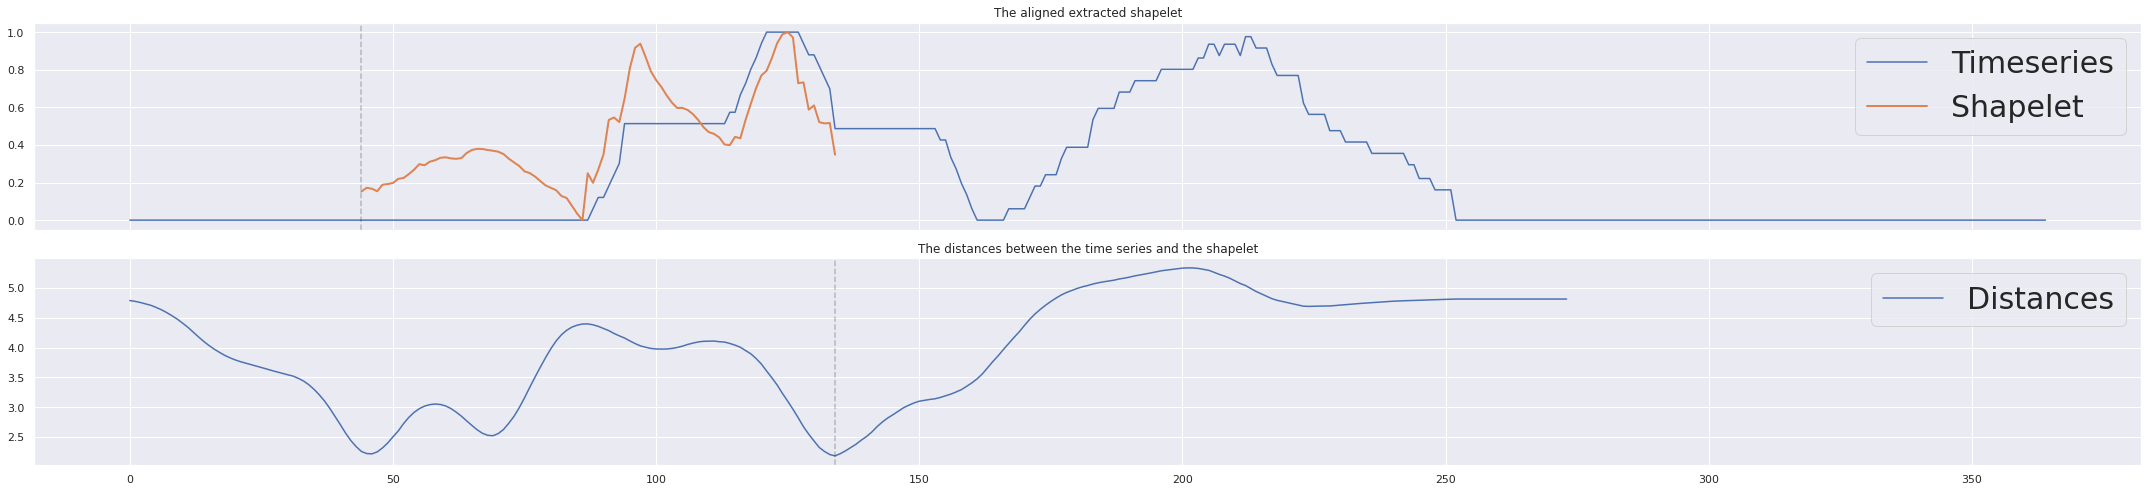

In [ ]:
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)
                                     
f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. 
test_ts_id = 90
shap = shp_clf.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel(), label="Timeseries")
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, label="Shapelet")
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")
ax[0].legend(prop={'size': 30})

# We calculate the distances from the shapelet to the timeseries ourselves.
distances = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances, label="Distances")
ax[1].axvline(np.argmin(distances), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.legend(prop={'size': 30})
plt.show()

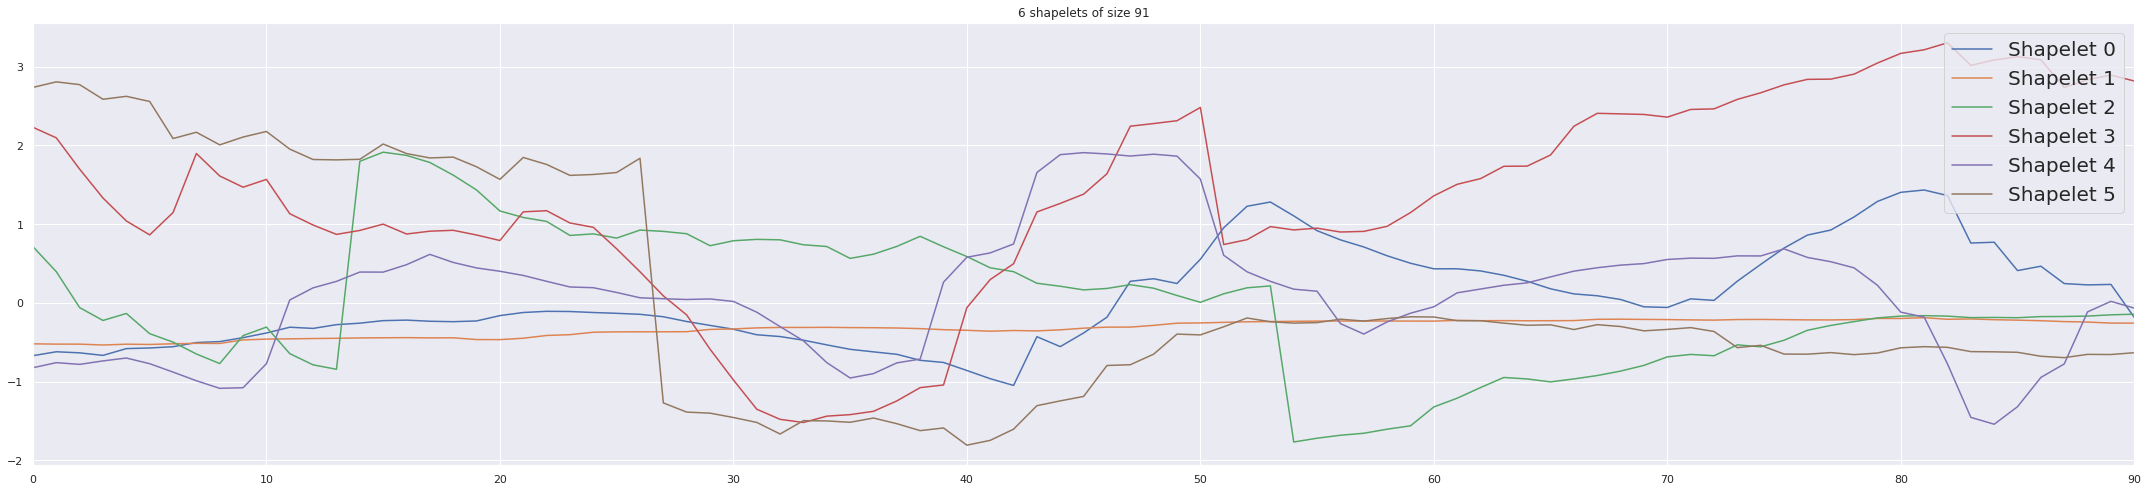

In [ ]:
from tslearn.utils import ts_size

# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for id, shp in enumerate(shp_clf.shapelets_):
        if ts_size(shp) == sz:
            plt.plot(shp.ravel(), label=f"Shapelet {id}")
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.legend(prop={'size': 20})
plt.show()

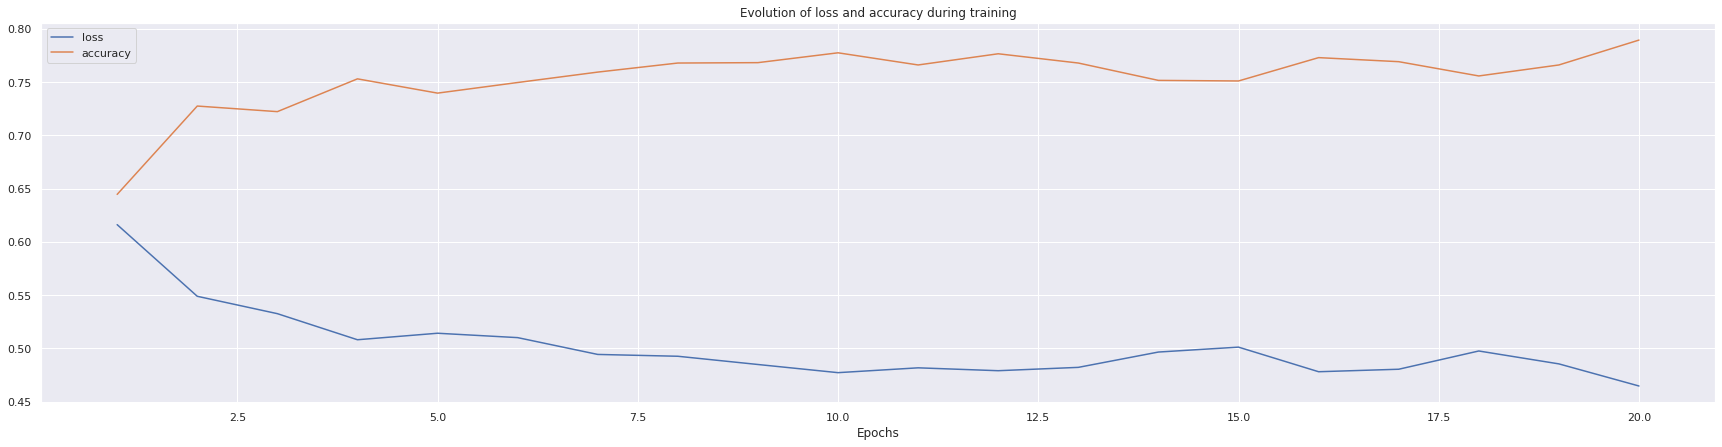

In [ ]:
# The loss and accuracy history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"], label="loss")
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["binary_accuracy"],label="accuracy")
plt.title("Evolution of loss and accuracy during training")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Classification using GRUs

In [ ]:
!pip install keras-tuner &> /dev/null

In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers

In [ ]:
from google.colab import drive

compute_model_selection = False

if compute_model_selection:
  drive.mount('/content/gdrive')

GRUs are a type of recurrent neural network used for modeling sequential data. They function similarly to other types of recurrent layers, such as LSTMs and RNNs, in that they take in a sequence of input data and produce a corresponding sequence of output data. However, GRUs differ in their use of "gates" which control the flow of information within the layer's internal memory. These gates, modeled using sigmoid activation functions, are trained using backpropagation and are beneficial because they are computationally efficient and easy to train.

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.GRU(units=hp.Int('units_layer1', min_value=8, max_value=512, step=8),
                         return_sequences=True,
                         kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_reg_layer1', values=[1e-2, 1e-3, 1e-4])),
                         input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.GRU(units=hp.Int('units_layer2', min_value=8, max_value=512, step=8),
                         kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_reg_layer2', values=[1e-2, 1e-3, 1e-4]))))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

Hyperband is a method for efficiently searching the hyperparameter space of a machine learning model. It is based on the idea of iteratively running trials with different combinations of hyperparameters, starting with a large number of trials with very little training, and then gradually increasing the number of trials and the amount of training for each trial as the search progresses.

In [ ]:
if compute_model_selection:
  tuner = Hyperband(build_model,
                    objective='val_accuracy',
                    max_epochs=20,
                    directory='my_dir',
                    project_name='my_project'+str(int(time.time())),)

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  tuner.search(X_train, y_train, validation_split=0.1, batch_size=64, callbacks=[early_stopping])

  best_model = tuner.get_best_models(num_models=1)[0]
  best_model.save('gdrive/MyDrive/best_model.h5')

else:
  best_model_id = "1-6Wb5PWsbv045ET22EyZ6KW0dXF6UIrc" 
  !gdown $best_model_id
  best_model = keras.models.load_model('best_model.h5')

Downloading...
From: https://drive.google.com/uc?id=1-6Wb5PWsbv045ET22EyZ6KW0dXF6UIrc
To: /content/best_model.h5
100% 11.0M/11.0M [00:00<00:00, 176MB/s]


In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 365, 496)          742512    
                                                                 
 gru_1 (GRU)                 (None, 96)                171072    
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 913,681
Trainable params: 913,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("test loss, test acc: ",best_model.evaluate(X_test, y_test))

44/44 [==============================] - 2s 24ms/step - loss: 0.7404 - accuracy: 0.7464
test loss, test acc:  [0.7403629422187805, 0.7463768124580383]
